In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 121.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 131.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 121.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 131.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 113.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=eaf3ead87eb222d55

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.1 MB/s eta 0:00:00a 0:00:01


# Analysis of clusters in sample S3

In [71]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [72]:
import importlib

## Preprocessing
### Read data

In [75]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")


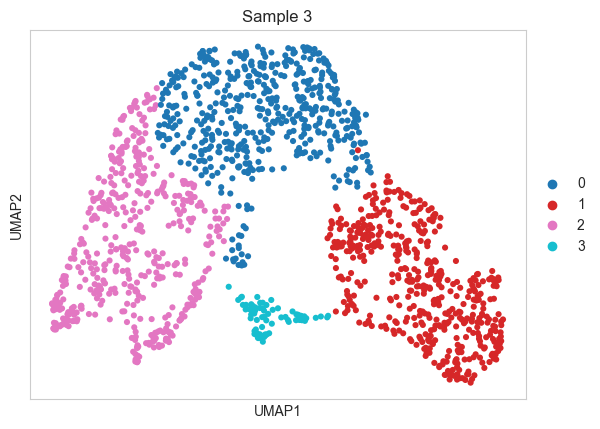

In [76]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [10]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB a

## Find optimal correlation matrix scaling and generate synthetic null data

In [ ]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

In [11]:
importlib.reload(cd)

data_gen_noscale, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)


xmin = 1.2360679772046799

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [12]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [13]:
data_null_gen.var_names

Index(['PA0001', 'PA0002', 'PA0003', 'PA0004', 'PA0005', 'PA0006', 'PA0007',
       'PA0008', 'PA0009', 'PA0010',
       ...
       'PA5561', 'PA5562', 'PA5563', 'PA5564', 'PA5565', 'PA5566', 'PA5567',
       'PA5568', 'PA5569', 'PA5570'],
      dtype='object', name='PAO1_ID', length=5546)

In [14]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [15]:
data_null_gen.var

,var_counts,mean_counts
PAO1_ID,,
PA0001,0.886218,0.712435
PA0002,0.732586,0.523964
PA0003,1.197131,0.913212
PA0004,0.465569,0.400907
PA0005,0.141982,0.141192
...,...,...
PA5566,0.013450,0.012306
PA5567,0.197106,0.147668
PA5568,0.703791,0.642487


In [16]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

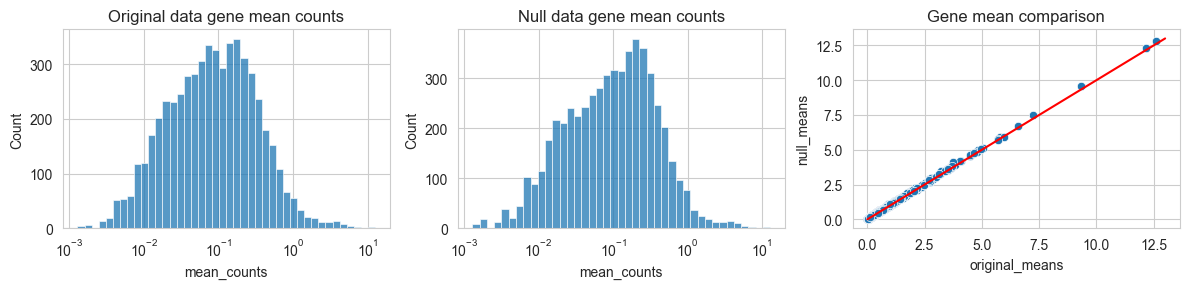

SignificanceResult(statistic=0.9968233661273043, pvalue=0.0)


In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

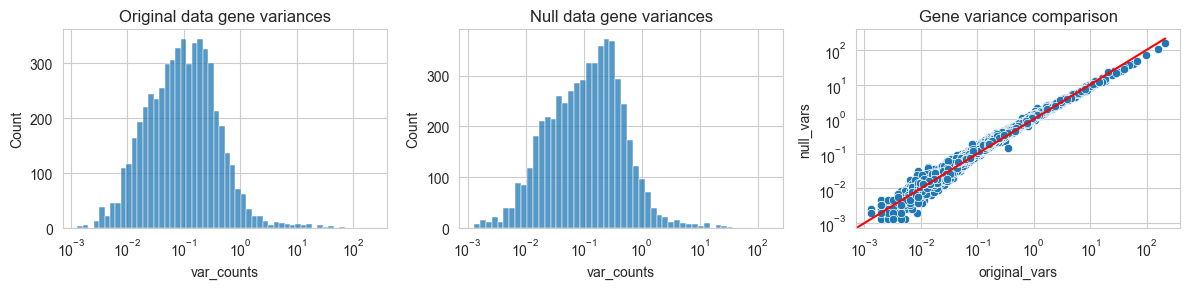

SignificanceResult(statistic=0.9946144943316074, pvalue=0.0)
[[1.         0.99531564]
 [0.99531564 1.        ]]


In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

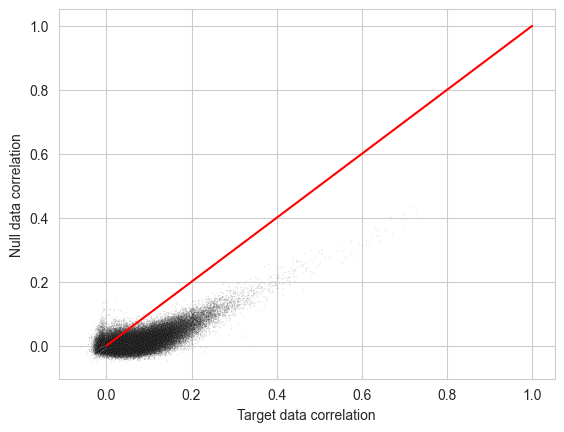

In [19]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [20]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [21]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


In [22]:
data_null_gen.var

,var_counts,mean_counts,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,n_cells_by_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mean,std
PAO1_ID,,,,,,,,,,,,,,,,,
PA0001,0.886218,0.712435,False,6.100217,6.100217,-8.537686,2.637794,-8.925563,2.754419,0.017341,729,0.537916,52.784974,1100.0,7.003974,0.696117,0.334178
PA0002,0.732586,0.523964,False,4.696913,4.696913,-8.426336,2.493148,NaN,NaN,NaN,555,0.421315,64.054404,809.0,6.697034,0.403662,0.364440
PA0003,1.197131,0.913212,False,6.411371,6.411371,-8.530869,2.713976,-9.048726,2.871205,0.015666,832,0.648784,46.113990,1410.0,7.252054,0.800491,0.351355
PA0004,0.465569,0.400907,False,3.547407,3.547407,-8.287879,2.374596,NaN,NaN,NaN,478,0.337120,69.041451,619.0,6.429719,0.115497,0.388179
PA0005,0.141982,0.141192,False,0.907871,0.907871,-7.279993,1.730378,NaN,NaN,NaN,203,0.132073,86.852332,218.0,5.389072,-1.267645,0.574229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,0.013450,0.012306,False,0.121185,0.121185,-5.732268,0.425495,NaN,NaN,NaN,18,0.012231,98.834197,19.0,2.995732,-3.455868,0.383243
PA5567,0.197106,0.147668,False,0.884606,0.884606,-7.255703,1.715307,-7.806692,1.902440,0.083684,180,0.137732,88.341969,228.0,5.433722,-1.306852,0.577090
PA5568,0.703791,0.642487,False,5.826956,5.826956,-8.522001,2.605759,NaN,NaN,NaN,700,0.496212,54.663212,992.0,6.900731,0.646695,0.341072


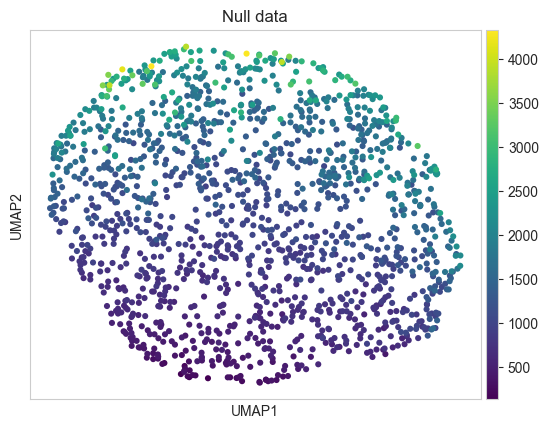

In [23]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [62]:
res2 = 0.01
twoclust = False
#345 vs. 456

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=234)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

0.05
0.1
Resolution for two clusters: 0.11


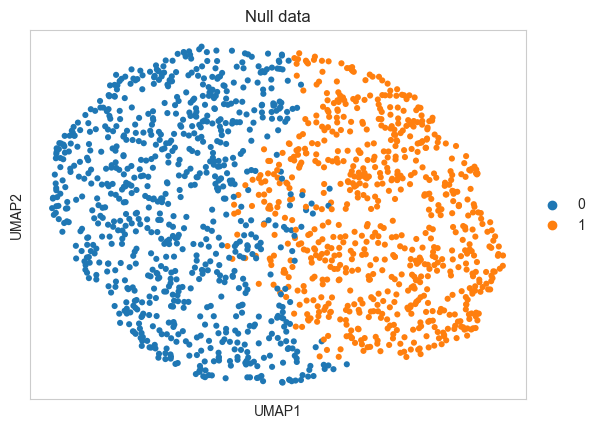

In [63]:
sc.pl.umap(data_null_gen, color="leiden", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [64]:
# data_null_gen.write("../../data/MOBA_scRNAseq/outs_S3/S3_null_data_opt.h5ad")


In [65]:
from scipy.stats import mannwhitneyu
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": mannwhitneyu(X_null_gen_0, X_null_gen_1, alternative="two-sided", method="asymptotic").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()

In [66]:
importlib.reload(cd)
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": mannwhitneyu(X_data_0, X_data_1, alternative="two-sided", method="asymptotic").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.11189303307529909
Cluster 1 - DE genes: 0; Minimum q value: 0.05263157894736842
Cluster 2 - DE genes: 4937; Minimum q value: 0.03046168491194669
Cluster 3 - DE genes: 0; Minimum q value: 1.0


In [67]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": mannwhitneyu(X_data_0, X_data_1, alternative="two-sided", method="asymptotic").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 361; Minimum q value: 0.045714285714285714
Cluster 1 - DE genes: 0; Minimum q value: 0.08333333333333333
Cluster 2 - DE genes: 2974; Minimum q value: 0.0070921985815602835
Cluster 3 - DE genes: 0; Minimum q value: 1.0


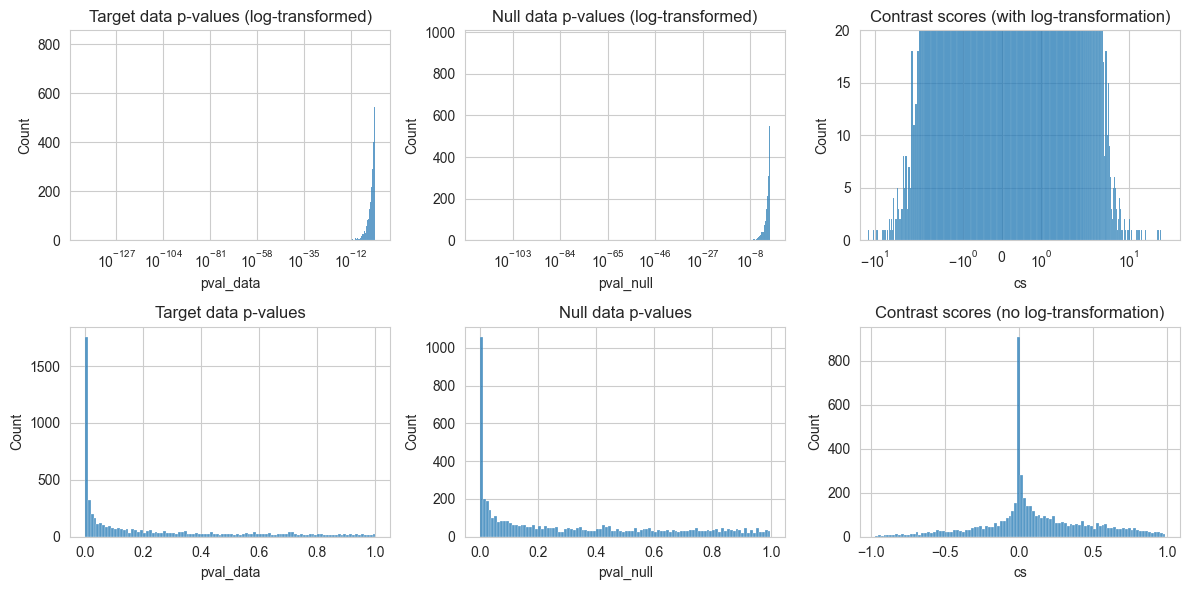

In [68]:
c = "1"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog",
            ylim=(0, 20)
            )

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [69]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
q
0.111893    2842
0.111930       8
0.112043     131
0.112226     209
0.112360      14
            ... 
0.204966       2
0.205050       3
0.205614       2
0.205697       3
1.000000     947
Name: count, Length: 315, dtype: int64

cluster 1
q
0.052632      19
0.150000       1
0.207595     375
0.208437       8
0.210396       1
            ... 
0.529754       1
0.530144       3
0.531656       1
0.531915       2
1.000000    1927
Name: count, Length: 666, dtype: int64

cluster 2
q
0.030462    2101
0.030499      63
0.030763     144
0.031088       8
0.031423      39
            ... 
0.070627       1
0.070986       2
0.071152       2
0.072298       1
1.000000     373
Name: count, Length: 188, dtype: int64

cluster 3
q
1.0    5546
Name: count, dtype: int64


In [70]:
pvals_log_gen[("3")]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA0624,1.888226e-94,2.576117e-01,93.723946,0.589034,93.134912,1.0
PA0636,4.949831e-93,1.775683e-01,92.305410,0.750635,91.554775,1.0
PA0617,4.144236e-92,5.367778e-01,91.382556,0.270205,91.112350,1.0
PA0643,3.898494e-89,1.069715e-01,88.409103,0.970732,87.438371,1.0
PA0633,5.367407e-85,1.513257e-01,84.270235,0.820087,83.450148,1.0
...,...,...,...,...,...,...
PA4256,6.802143e-01,1.572690e-109,0.167354,108.803357,-108.636003,1.0
PA4267,4.434124e-01,1.066828e-110,0.353192,109.971905,-109.618713,1.0
PA4260,7.311233e-01,3.366377e-111,0.136009,110.472837,-110.336828,1.0


In [44]:
for c in clusters:
    print(c)
    print(len(pvals_log_gen[c][pvals_log_gen[c]["q"] < 0.15]))
    print("")

0
3905

1
0

2
5155

3
0


In [45]:
pvals_log_gen["2"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA1603,8.550128e-35,1.557382e-04,34.068027,3.807605,30.260422,0.0349
PA2932,1.081899e-32,1.213960e-03,31.965813,2.915796,29.050018,0.0349
PA3683,1.928489e-31,5.372284e-03,30.714783,2.269841,28.444942,0.0349
PA1854,2.705667e-35,1.049221e-07,34.567726,6.979133,27.588593,0.0349
PA0774,1.402854e-29,4.831760e-02,28.852988,1.315895,27.537093,0.0349
...,...,...,...,...,...,...
PA4255,1.351079e-38,1.348058e-76,37.869319,75.870292,-38.000972,1.0000
PA4385,1.936371e-43,2.102710e-82,42.713011,81.677221,-38.964209,1.0000
PA4254,2.726609e-63,4.964192e-103,62.564377,102.304151,-39.739774,1.0000


['PA4264', 'PA4260', 'PA4262', 'PA4256', 'PA4251', 'PA4267', 'PA4252', 'PA4274', 'PA4250', 'PA5556']


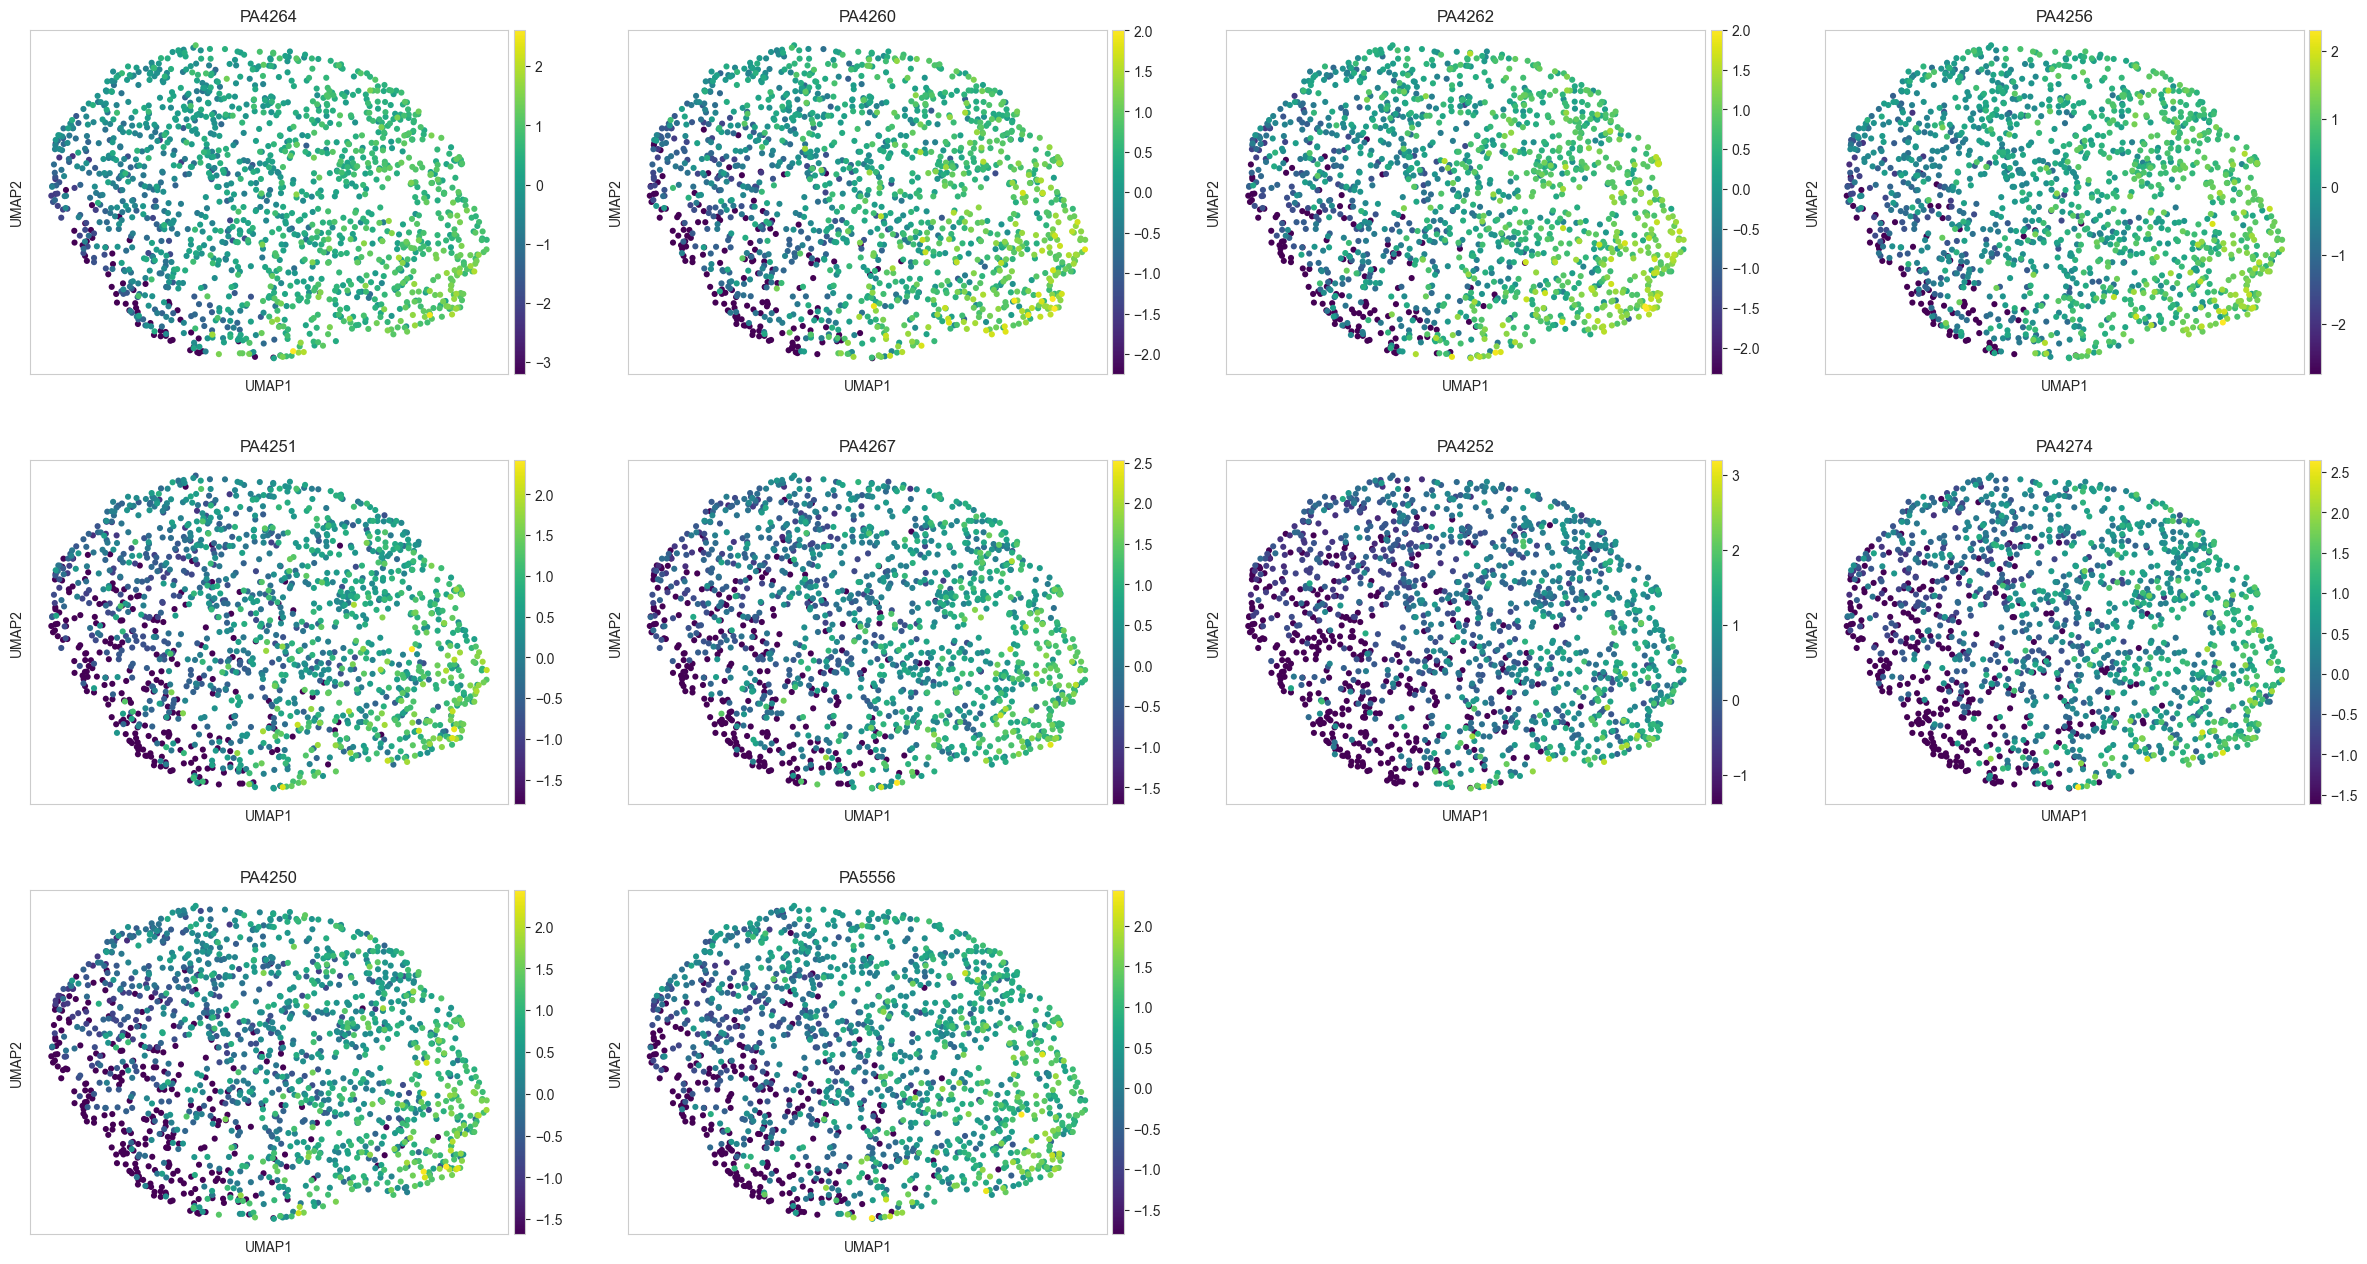

In [46]:
# goi = pvals_log_gen["3"].sort_values("pval_null", ascending=True).index[:10]
goi = ['PA4264', 'PA4260', 'PA4262', 'PA4256', 'PA4251', 'PA4267', 'PA4252',
       'PA4274', 'PA4250', 'PA5556']
print(goi)

sc.pl.umap(data_null_gen, color=goi, cmap="viridis")

## Testing...

In [30]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, flavor="sctransform", layer="counts")


Index(['Intercept_sct', 'log_umi_sct', 'theta_sct', 'is_scd_outlier_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct', 'is_scd_outlier'],
      dtype='object')


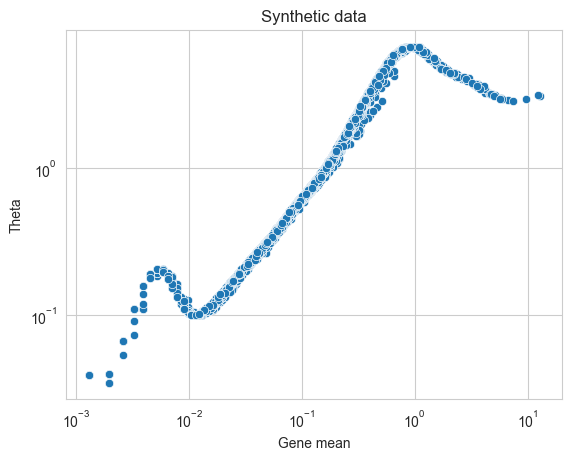

In [31]:
g = sns.scatterplot(data=data_null_gen.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Synthetic data")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

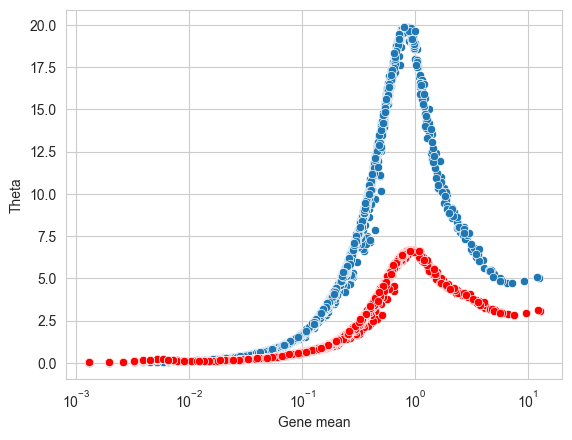

In [32]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
sns.scatterplot(data=data_null_gen.var, y="nb_overdisp_cutoff", x="mean_counts", color="red")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [53]:
nb_est_df_null = data_null_gen.var.reset_index()[["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "mean_counts", "var_counts", "n_cells_by_counts", "PAO1_ID", "nb_umi", "Intercept_step1_sct", "log_umi_step1_sct", "dispersion_step1_sct", "total_counts"]]
nb_est_df_null["type"] = "null"
nb_est_df_gene = data_gene.var[["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "mean_counts", "var_counts", "n_cells_by_counts", "PAO1_ID", "nb_umi", "Intercept_step1_sct", "log_umi_step1_sct", "dispersion_step1_sct", "total_counts"]]
nb_est_df_gene["type"] = "real"

nb_est_df = pd.concat([nb_est_df_null, nb_est_df_gene])
nb_est_df

,nb_mean,nb_overdisp,nb_overdisp_cutoff,mean_counts,var_counts,n_cells_by_counts,PAO1_ID,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,total_counts,type
0,-8.534788,6.168704,6.168704,0.712435,0.886218,729,PA0001,2.636814,-8.925563,2.754419,0.017341,1100.0,null
1,-8.479308,4.452463,4.452463,0.523964,0.732586,555,PA0002,2.510505,-9.430368,2.816549,0.046622,809.0,null
2,-8.478799,6.651865,6.651865,0.913212,1.197131,832,PA0003,2.697069,NaN,NaN,NaN,1410.0,null
3,-8.352816,3.300785,3.300785,0.400907,0.465569,478,PA0004,2.395943,-9.917083,2.885378,0.018295,619.0,null
4,-7.130220,0.882145,0.882145,0.141192,0.141982,203,PA0005,1.682797,NaN,NaN,NaN,218.0,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,-11.909152,0.114507,0.114507,0.009715,0.010916,14,PA5566,2.353771,-7.586299,0.980230,0.034549,15.0,real
PA5567,-9.794967,2.285935,2.285935,0.126943,0.161347,163,PA5567,2.502667,-9.934617,2.556388,0.029657,196.0,real
PA5568,-7.085377,18.322180,18.322180,0.659974,0.750315,740,PA5568,2.183642,NaN,NaN,NaN,1019.0,real
PA5569,-5.555596,6.463974,6.463974,3.498057,14.170981,1430,PA5569,2.223996,-6.188664,2.421585,0.057214,5401.0,real


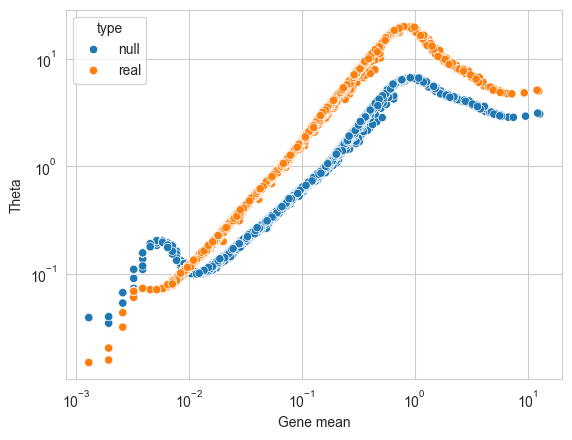

In [54]:
g = sns.scatterplot(data=nb_est_df, y="nb_overdisp_cutoff", x="mean_counts", hue="type")
g.set(xscale="log", yscale="log")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

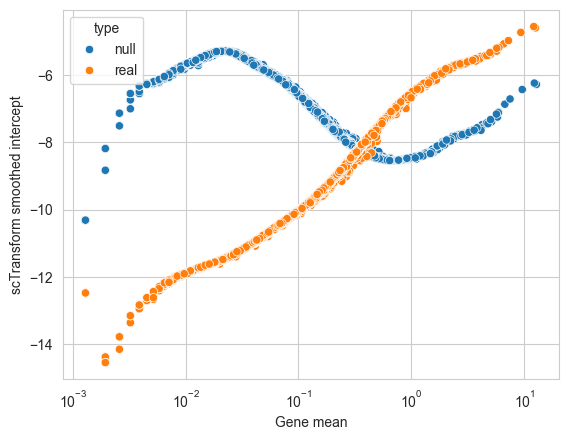

In [55]:
g = sns.scatterplot(data=nb_est_df, y="nb_mean", x="mean_counts", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform smoothed intercept")
plt.show()

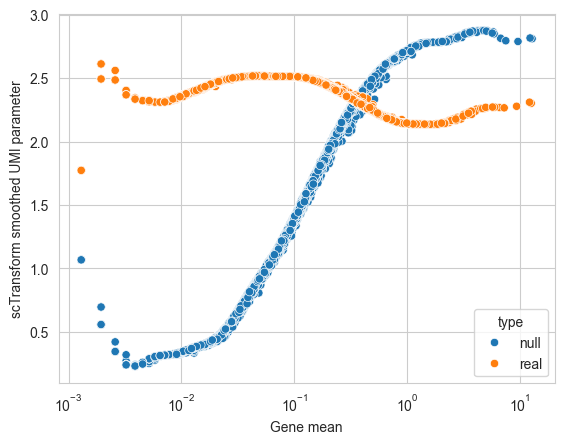

In [56]:
g = sns.scatterplot(data=nb_est_df, y="nb_umi", x="mean_counts", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform smoothed UMI parameter")
plt.show()

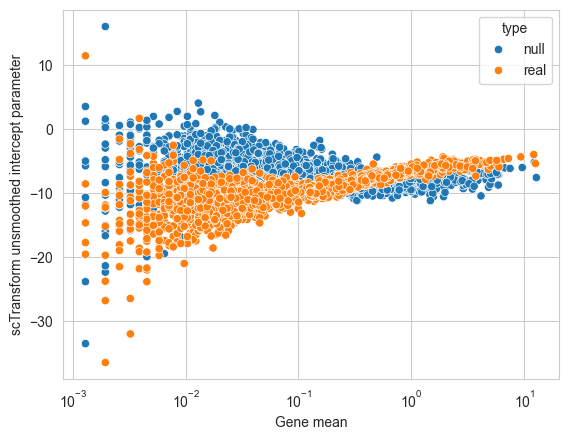

In [57]:
g = sns.scatterplot(data=nb_est_df, y="Intercept_step1_sct", x="mean_counts", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform unsmoothed intercept parameter")
plt.show()

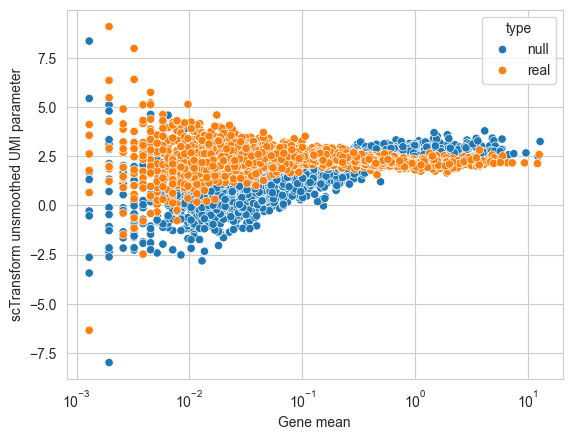

In [58]:
g = sns.scatterplot(data=nb_est_df, y="log_umi_step1_sct", x="mean_counts", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform unsmoothed UMI parameter")
plt.show()

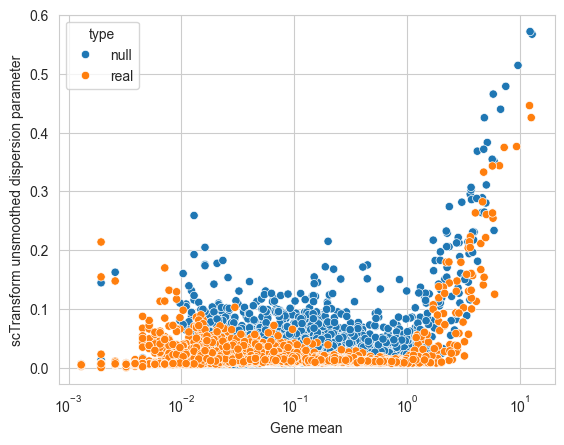

In [59]:
g = sns.scatterplot(data=nb_est_df, y="dispersion_step1_sct", x="mean_counts", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform unsmoothed dispersion parameter")
plt.show()

In [60]:
nb_est_df_paired = nb_est_df.pivot(index="PAO1_ID", columns="type")
nb_est_df_paired.columns = ['_'.join(col).strip() for col in nb_est_df_paired.columns.values]
nb_est_df_paired

,nb_mean_null,nb_mean_real,nb_overdisp_null,nb_overdisp_real,nb_overdisp_cutoff_null,nb_overdisp_cutoff_real,mean_counts_null,mean_counts_real,var_counts_null,var_counts_real,...,nb_umi_null,nb_umi_real,Intercept_step1_sct_null,Intercept_step1_sct_real,log_umi_step1_sct_null,log_umi_step1_sct_real,dispersion_step1_sct_null,dispersion_step1_sct_real,total_counts_null,total_counts_real
PAO1_ID,,,,,,,,,,,,,,,,,,,,,
PA0001,-8.534788,-7.078398,6.168704,18.381380,6.168704,18.381380,0.712435,0.666451,0.886218,0.755973,...,2.636814,2.182879,-8.925563,-6.941972,2.754419,2.135988,0.017341,0.009296,1100.0,1029.0
PA0002,-8.479308,-7.687153,4.452463,12.470362,4.452463,12.470362,0.523964,0.468912,0.732586,0.588412,...,2.510505,2.255502,-9.430368,-7.928057,2.816549,2.336558,0.046622,0.012938,809.0,724.0
PA0003,-8.478799,-6.658154,6.651865,19.568203,6.651865,19.568203,0.913212,0.893782,1.197131,1.043122,...,2.697069,2.145825,NaN,-6.444100,NaN,2.071128,NaN,0.008896,1410.0,1380.0
PA0004,-8.352816,-8.034767,3.300785,9.652224,3.300785,9.652224,0.400907,0.373705,0.465569,0.398557,...,2.395943,2.300569,-9.917083,NaN,2.885378,NaN,0.018295,NaN,619.0,577.0
PA0005,-7.130220,-9.801467,0.882145,2.269367,0.882145,2.269367,0.141192,0.120466,0.141982,0.124089,...,1.682797,2.503061,NaN,NaN,NaN,NaN,NaN,NaN,218.0,186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,-5.553185,-11.909152,0.101246,0.114507,0.101246,0.114507,0.012306,0.009715,0.013450,0.010916,...,0.368519,2.353771,-6.783261,-7.586299,0.776778,0.980230,0.027348,0.034549,19.0,15.0
PA5567,-7.097171,-9.794967,0.862057,2.285935,0.862057,2.285935,0.147668,0.126943,0.197106,0.161347,...,1.664879,2.502667,-7.806692,-9.934617,1.902440,2.556388,0.083684,0.029657,228.0,196.0
PA5568,-8.539576,-7.085377,5.807612,18.322180,5.807612,18.322180,0.642487,0.659974,0.703791,0.750315,...,2.611428,2.183642,-7.611846,NaN,2.307249,NaN,0.013207,NaN,992.0,1019.0


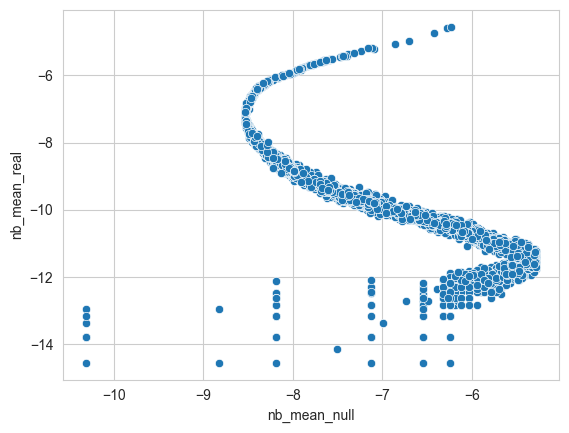

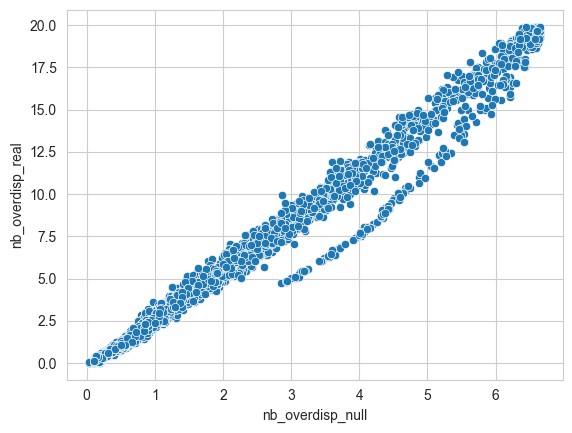

In [61]:
sns.scatterplot(nb_est_df_paired, x="nb_mean_null", y="nb_mean_real")
plt.show()

sns.scatterplot(nb_est_df_paired, x="nb_overdisp_null", y="nb_overdisp_real")
plt.show()

In [65]:
nb_est_df_paired["total_counts"] = nb_est_df["total_counts"]
nb_est_df_paired["nb_est_real"] = nb_est_df_paired["Intercept_step1_sct_real"] + nb_est_df_paired["log_umi_step1_sct_real"] * np.log10(nb_est_df_paired["total_counts"])
nb_est_df_paired["nb_est_null"] = nb_est_df_paired["Intercept_step1_sct_null"] + nb_est_df_paired["log_umi_step1_sct_null"] * np.log10(nb_est_df_paired["total_counts"])

nb_est_df_paired["nb_est_real_smoothed"] = nb_est_df_paired["nb_mean_real"] + nb_est_df_paired["nb_umi_real"] * np.log10(nb_est_df_paired["total_counts"])
nb_est_df_paired["nb_est_null_smoothed"] = nb_est_df_paired["nb_mean_null"] + nb_est_df_paired["nb_umi_null"] * np.log10(nb_est_df_paired["total_counts"])

nb_est_df_paired

,nb_mean_null,nb_mean_real,nb_overdisp_null,nb_overdisp_real,nb_overdisp_cutoff_null,nb_overdisp_cutoff_real,mean_counts_null,mean_counts_real,var_counts_null,var_counts_real,...,dispersion_step1_sct_null,dispersion_step1_sct_real,total_counts_null,total_counts_real,gene_mean,total_counts,nb_est_real,nb_est_null,nb_est_real_smoothed,nb_est_null_smoothed
PAO1_ID,,,,,,,,,,,,,,,,,,,,,
PA0001,-8.534788,-7.078398,6.168704,18.381380,6.168704,18.381380,0.712435,0.666451,0.886218,0.755973,...,0.017341,0.009296,1100.0,1029.0,0.666451,1029.0,-0.507489,-0.628110,-0.502660,-0.591608
PA0002,-8.479308,-7.687153,4.452463,12.470362,4.452463,12.470362,0.523964,0.468912,0.732586,0.588412,...,0.046622,0.012938,809.0,724.0,0.468912,724.0,-1.246113,-1.375775,-1.237007,-1.299921
PA0003,-8.478799,-6.658154,6.651865,19.568203,6.651865,19.568203,0.913212,0.893782,1.197131,1.043122,...,NaN,0.008896,1410.0,1380.0,0.893782,1380.0,0.058992,NaN,0.079477,-0.010328
PA0004,-8.352816,-8.034767,3.300785,9.652224,3.300785,9.652224,0.400907,0.373705,0.465569,0.398557,...,0.018295,NaN,619.0,577.0,0.373705,577.0,NaN,-1.950045,-1.682491,-1.737195
PA0005,-7.130220,-9.801467,0.882145,2.269367,0.882145,2.269367,0.141192,0.120466,0.141982,0.124089,...,NaN,NaN,218.0,186.0,0.120466,186.0,NaN,NaN,-4.120738,-3.311091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,-5.553185,-11.909152,0.101246,0.114507,0.101246,0.114507,0.012306,0.009715,0.013450,0.010916,...,0.027348,0.034549,19.0,15.0,0.009715,15.0,-6.433459,-5.869699,-9.140902,-5.119773
PA5567,-7.097171,-9.794967,0.862057,2.285935,0.862057,2.285935,0.147668,0.126943,0.197106,0.161347,...,0.083684,0.029657,228.0,196.0,0.126943,196.0,-4.074722,-3.445811,-4.058213,-3.280842
PA5568,-8.539576,-7.085377,5.807612,18.322180,5.807612,18.322180,0.642487,0.659974,0.703791,0.750315,...,0.013207,NaN,992.0,1019.0,0.659974,1019.0,NaN,-0.671240,-0.516603,-0.683946


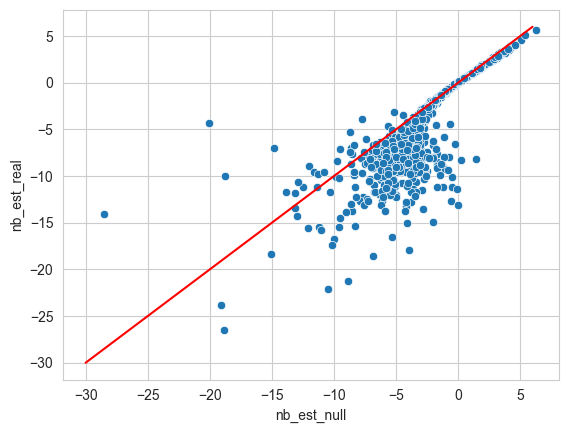

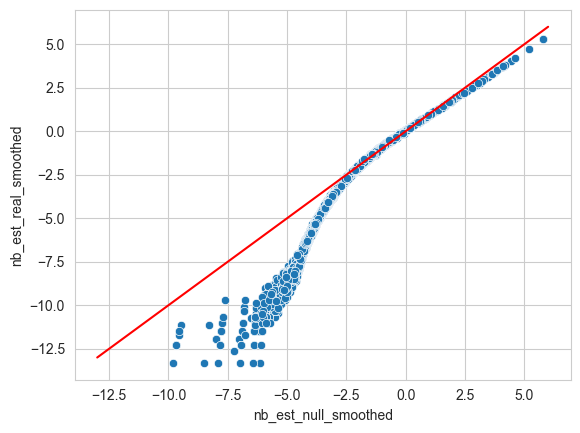

In [68]:
g = sns.scatterplot(nb_est_df_paired, x="nb_est_null", y="nb_est_real")
g.plot([-30, 6], [-30, 6], color="red")

plt.show()

g = sns.scatterplot(nb_est_df_paired, x="nb_est_null_smoothed", y="nb_est_real_smoothed")
g.plot([-13, 6], [-13, 6], color="red")
plt.show()

In [43]:
data_null_gen.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,leiden
AAACCCAGTGGACCTC-1,1259,7.138867,2650.0,7.882692,0
AAACCCATCCTGTAGA-1,1493,7.309212,2947.0,7.988882,1
AAACGCTCAGATTTCG-1,526,6.267201,911.0,6.815640,0
AAACGCTTCTTTGCTA-1,545,6.302619,797.0,6.682109,0
AAAGAACCAGTCTGGC-1,932,6.838405,1450.0,7.280008,0
...,...,...,...,...,...
TTTGATCTCCTCGCAT-1,1014,6.922644,1744.0,7.464510,0
TTTGGAGCACCGAATT-1,709,6.565265,918.0,6.823286,1
TTTGGAGCAGCAGTTT-1,443,6.095825,542.0,6.297109,1
TTTGGTTTCGTTGTGA-1,865,6.763885,1406.0,7.249215,0


In [44]:
cell_df_null = data_null_gen.obs.reset_index()[["total_counts", "n_genes_by_counts"]]
cell_df_null["type"] = "null"
cell_df_gene = data_gene.obs[["total_counts", "n_genes_by_counts"]]
cell_df_gene["type"] = "real"

cell_df = pd.concat([cell_df_gene, cell_df_null])

<Axes: xlabel='total_counts', ylabel='Count'>

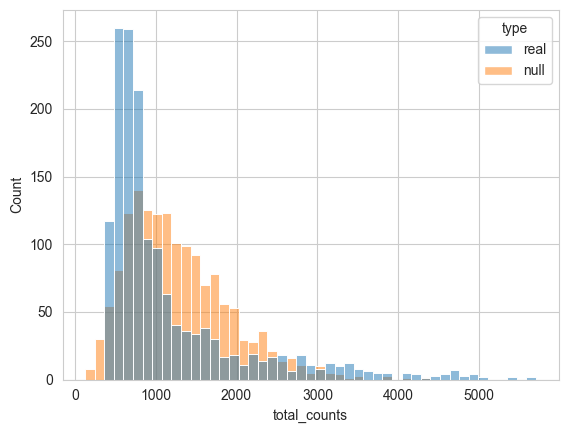

In [45]:
sns.histplot(cell_df, x="total_counts", hue="type")

In [46]:
# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_counts = pd.DataFrame({"count_orig": data_gene_nonzero.layers["counts"].toarray().flatten(), "count_gen": data_null_gen.layers["counts"].flatten()})
count_pairs = all_counts.groupby(['count_orig','count_gen']).size().reset_index().rename(columns={0:'count'})
count_pairs["log_count"] = np.log(count_pairs["count"])
count_pairs = count_pairs.pivot(index="count_gen", columns="count_orig", values="log_count")
count_pairs


count_orig,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,99.0,100.0,101.0,102.0,103.0,104.0,107.0,114.0,129.0,136.0
count_gen,,,,,,,,,,,,,,,,,,,,,
0.0,15.692543,13.361837,11.672175,10.088638,8.978913,8.072467,7.407924,6.830874,6.406880,6.028279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,13.396948,11.976238,10.620595,9.345832,8.398860,7.667626,7.093405,6.565265,6.196444,5.805135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2.0,11.835321,10.833583,9.721666,8.674368,7.908755,7.280008,6.701960,6.378426,5.918894,5.480639,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3.0,10.465814,9.809452,8.899867,8.075583,7.441907,6.916715,6.418365,5.924256,5.616771,5.257495,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4.0,9.251866,8.924257,8.256867,7.596894,7.016610,6.439350,6.063785,5.669881,5.370638,5.049856,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
all_counts.reset_index()

,index,count_orig,count_gen
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,1.0
3,3,0.0,0.0
4,4,0.0,1.0
...,...,...,...
8563019,8563019,0.0,0.0
8563020,8563020,0.0,0.0
8563021,8563021,1.0,1.0
8563022,8563022,6.0,3.0


In [48]:
all_counts_long = pd.wide_to_long(all_counts.reset_index(), stubnames="count", i="index", j="type", sep="_", suffix=r'\w+').reset_index()
all_counts_long

,index,type,count
0,0,orig,0.0
1,1,orig,0.0
2,2,orig,0.0
3,3,orig,0.0
4,4,orig,0.0
...,...,...,...
17126043,8563019,gen,0.0
17126044,8563020,gen,0.0
17126045,8563021,gen,1.0
17126046,8563022,gen,3.0


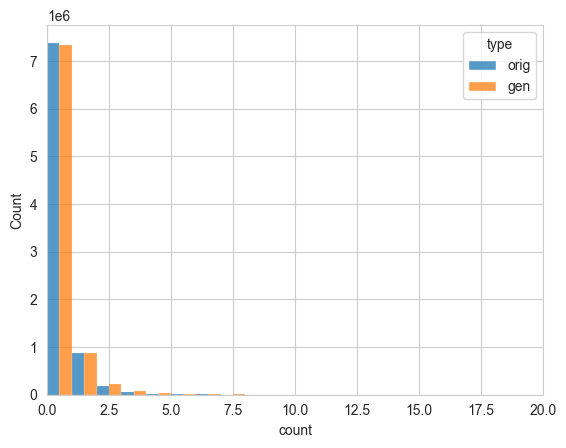

In [49]:
g = sns.histplot(all_counts_long, x="count", hue="type", binwidth=1, multiple="dodge")
g.set(xlim=(0, 20))
plt.show()